In [2]:
import numpy as np
import pandas as pd
import cv2
import random
import skimage.io as io
from skimage.color import gray2rgb
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from matplotlib.path import Path

dataDir='data'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
cocoData = COCO(annFile)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [11]:
def segmentTo2DArray(segmentation):
    polygon = []
    for partition in segmentation:
        for x, y in zip(partition[::2], partition[1::2]):
            polygon.append((x, y))
    return polygon


def maskPixels(polygon, img_dict):    
    img = cv2.imread('data/val2017/' + img_dict['file_name'])    
    mask = np.zeros(img.shape, dtype=np.uint8)   
    polygon = np.int32(polygon)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    masked_image = cv2.bitwise_and(img, mask)
    cv2.imshow("same size" , masked_image)
    cv2.waitKey()
    return masked_image


def getSegmentedMasks(filterClasses):
    # Returns single object annotation with background removed
    dataDir = 'data'
    dataType = 'val2017'
    catIds = cocoData.getCatIds(catNms=filterClasses)
    imgIds = cocoData.getImgIds(catIds=catIds)

    if len(imgIds) > 500:
        imgIds = random.sample(imgIds, 500)
    imgs = cocoData.loadImgs(imgIds)

    segmented_masks = []
    for img in imgs:
        # Load image
        loaded_img = io.imread('{}/{}/{}'.format(dataDir, dataType, img['file_name'])) / 255.0
        if len(loaded_img.shape) == 2:
            loaded_img = gray2rgb(loaded_img)

        # Load annotations
        annIds = cocoData.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=0)
        anns = cocoData.loadAnns(annIds)

        for ann in anns:
            polyVerts = segmentTo2DArray(ann['segmentation'])
            img_mask = maskPixels(polyVerts, img)
            segmented_masks.append(img_mask)
    return segmented_masks

print("Loading object masks...")
segmented_masks = getSegmentedMasks(["person"])

Loading object masks...
(640, 480, 3)
(640, 480, 3)
(480, 640, 3)
(480, 640, 3)
(478, 640, 3)
(478, 640, 3)
(640, 480, 3)
(640, 480, 3)
(640, 480, 3)
(640, 480, 3)
(640, 480, 3)
(640, 480, 3)


KeyboardInterrupt: 

In [39]:
def imageHist(image, bins=(4, 6, 3)):
    valid_pix = np.float32(image.reshape(-1, 3))
    valid_pix = valid_pix[np.all(valid_pix != 0, axis=1), :]
    if valid_pix.shape[0] > 0:
        # compute a 3D color histogram over the image and normalize it
        hist = cv2.calcHist(valid_pix, [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        # return the histogram
        return hist


def loadHistograms(images, bins):
    data = []
    for image in images:
        img_float32 = np.float32(image)
        image = cv2.cvtColor(img_float32, cv2.COLOR_RGB2HSV)
        features = imageHist(image, bins)
        if features is not None:
            data.append(features)
            print(features.shape)
    return np.array(data)

In [ ]:
# Supervised learning, assuming X train does not contain anomalies
print("Preparing dataset...")
x_train_masks, x_test_masks = train_test_split(segmented_masks, test_size=0.3)  
x_train_features = loadHistograms(x_train_masks, bins=(3, 3, 3))
x_test_features = loadHistograms(x_test_masks, bins=(3, 3, 3))

print("Fitting anomaly detection model...")
model = IsolationForest(behaviour='new', n_estimators=100, contamination=0.01, random_state=42)
model.fit(x_train_features)

print("Predicting outliers...")
for obj_features, mask in zip(x_test_features, x_test_masks):
    pred = model.predict([obj_features])[0]
    label = 'anomaly' if pred == -1 else 'normal'
    color = (255, 0, 0) if pred == -1 else (0, 255, 0)
    
    cv2.putText(mask, label, (10,  25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    if label == 'anomaly':
        mask = np.float32(mask)
        RGB_img = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        cv2.imshow("Output", RGB_img)
        cv2.waitKey(0)

In [ ]:
# Unsupervised learning
print("Preparing dataset...")
train_features = loadHistograms(segmented_masks, bins=(3, 3, 3))
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

print("Fitting anomaly detection model...")
results = pd.DataFrame()
results['lof'] = lof.fit_predict(train_features)
results['negative_outlier_factor'] = lof.negative_outlier_factor_
outliers = results[results['lof'] == -1]

Preparing dataset...
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(

(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,)
(27,

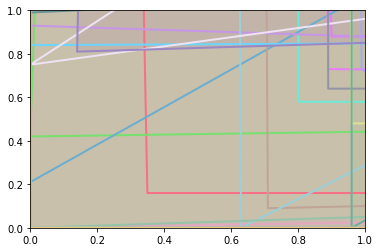

In [40]:
def getOutliers(filterClasses, nn=20, contamination=0.1):
#     print("Loading object masks...")
#     segmented_masks = getSegmentedMasks(filterClasses)
    
    print("Preparing dataset...")
    train_features = loadHistograms(segmented_masks, bins=(3, 3, 3))
    lof = LocalOutlierFactor(n_neighbors=nn, contamination=contamination)
    
    print("Fitting anomaly detection model...")
    results = pd.DataFrame()
    results['lof'] = lof.fit_predict(train_features)
    results['negative_outlier_factor'] = lof.negative_outlier_factor_
    outliers = results[results['lof'] == -1]
    return results
    

def getOutlyingImgs(filterClasses, preds):
    catIds = cocoData.getCatIds(catNms=filterClasses)
    imgIds = cocoData.getImgIds(catIds=catIds)
    annIds = cocoData.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=0)
    anns = cocoData.loadAnns(annIds)
    cocoData.showAnns(anns)
    
    outlying_objs_anns = []
    for annId, pred in zip(annIds, preds):
        if pred == -1:
            outlying_objs_anns.append(annId)
            
    imgs_with_outliers = []
    for img in imgIds:
        img_anns = set(cocoData.getAnnIds(imgIds=[img]))
        outlying_anns = set(outlying_objs_anns)
        if len(img_anns.intersection(outlying_anns)) > 0:
            imgs_with_outliers.append(img)
    return imgs_with_outliers

preds_df = getOutliers(["person"])
outlier_imgIds = getOutlyingImgs(["person"], preds_df['lof'])
print(outlier_imgIds)